In [0]:
import os, types
import numpy as np
import pandas as pd
from skimage import io as skyio
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint
import cv2

In [0]:
storageaccount="dang"
account_key="ding"
containername="dong"
mountname="containaname"

spark.conf.set(
  "fs.azure.account.key."+storageaccount+".blob.core.windows.net",
  account_key)

In [0]:
dbutils.fs.mount(
  source = "wasbs://" + containername + "@" + storageaccount + ".blob.core.windows.net",
  mount_point = "/mnt/" + mountname,
  extra_configs = {"fs.azure.account.key." + storageaccount +".blob.core.windows.net":account_key})

Out[5]: True

In [0]:
df = spark.read.format("image").option("dropInvalid", True).load("/mnt/" + mountname+'/')
df.select("image.origin", "image.width", "image.height").show(truncate=False)

+---------------------------------+-----+------+
origin |width|height|
+---------------------------------+-----+------+
dbfs:/mnt/containaname/ams20.jpg |200 |200 |
dbfs:/mnt/containaname/mosque.jpg|200 |200 |
+---------------------------------+-----+------+

In [0]:
dbutils.fs.unmount("/mnt/" + mountname)

/mnt/containername has been unmounted.
Out[32]: True

In [0]:
stl="/dbfs/mnt/" + mountname+"/ams20.jpg"
ctt="/dbfs/mnt/" + mountname+"/mosque.jpg"
    
original_image = cv2.imread(stl)

print(original_image.shape)
img=cv2.cvtColor(original_image,cv2.COLOR_BGR2RGB)
#Image.open(stl)

(200, 200, 3)

In [0]:
def reshape(pic, n):
    imgs = Image.open(pic) 
    imgs.thumbnail((n, n))
    return imgs.save(pic)

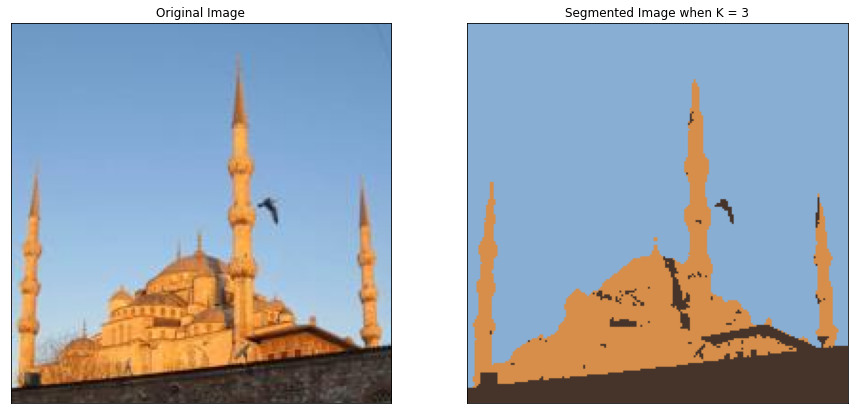

[0 1]

In [0]:
original_image = cv2.imread(content_img)
img=cv2.cvtColor(original_image,cv2.COLOR_BGR2RGB)
vectorized = img.reshape((-1,3))
vectorized = np.float32(vectorized)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

K = 3
attempts=200
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS) 

center = np.uint8(center)

res = center[label.flatten()]
result_image = res.reshape((img.shape))

figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

mask1=np.where(result_image==[137, 174, 212], [0,0,0], result_image)
mask11=np.where(result_image==[70,  51,  41], [0,0,0], mask1)
mask2=np.where(result_image==[214, 142,  74], [1,1,1], mask11)
mask=np.array([mask2])
print(np.unique(mask))

In [0]:
content_img="/dbfs/mnt/" + mountname+"/mosque.jpg"
style_img="/dbfs/mnt/" + mountname+"/ams20.jpg"

#reshape(style_img,200)
mask.shape

Out[44]: (1, 200, 200, 3)

<keras.engine.functional.Functional object at 0x7f101388faf0>
Epoch 0

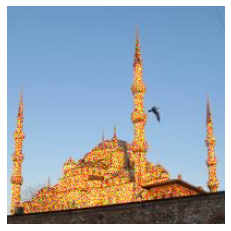

Epoch 10 
Epoch 20 
Epoch 30 
Epoch 40 
Epoch 50 
Epoch 60 
Epoch 70 
Epoch 80 
Epoch 90 
Epoch 100

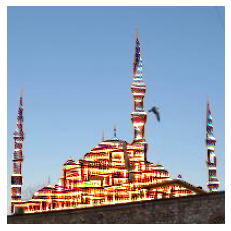

Epoch 110 
Epoch 120 
Epoch 130 
Epoch 140 
Epoch 150 
Epoch 160 
Epoch 170 
Epoch 180 
Epoch 190 
Epoch 200

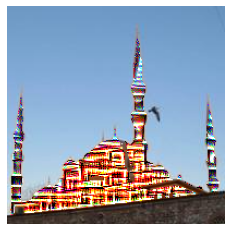

Epoch 210 
Epoch 220 
Epoch 230 
Epoch 240 
Epoch 250 
Epoch 260 
Epoch 270 
Epoch 280 
Epoch 290 
Epoch 300

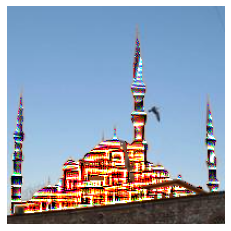

Epoch 310 
Epoch 320 
Epoch 330 
Epoch 340 
Epoch 350 
Epoch 360 
Epoch 370 
Epoch 380 
Epoch 390 
Epoch 400

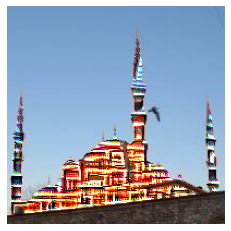

Epoch 410 
Epoch 420 
Epoch 430 
Epoch 440 
Epoch 450 
Epoch 460 
Epoch 470 
Epoch 480 
Epoch 490 
Epoch 500

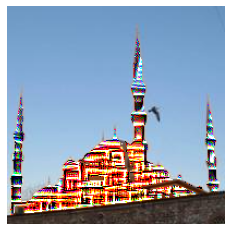

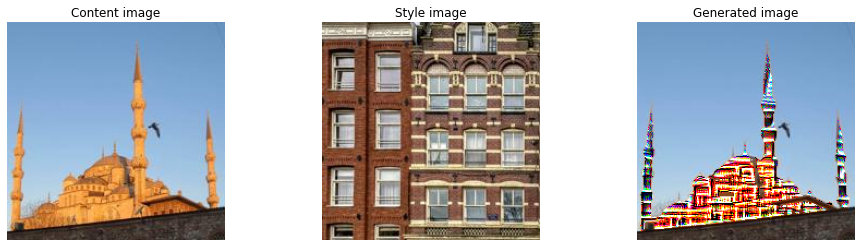

In [0]:
content_img="/dbfs/mnt/" + mountname+"/mosque.jpg"
style_img="/dbfs/mnt/" + mountname+"/ams20.jpg"

#style_img=reshape(style_img,200)

pp = pprint.PrettyPrinter(indent=4)
img_size = 200
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='imagenet')

vgg.trainable = False
pp.pprint(vgg)

def compute_content_cost(content_output, generated_output):
    a_C = content_output[-1]
    a_G = generated_output[-1]    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()    
    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_H * n_W, n_C])   
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled)))/(4* n_H*n_W*n_C)
    
    return J_content


def gram_matrix(A):
    GA = tf.matmul(A,tf.transpose(A))
    
    return GA


def compute_layer_style_cost(a_S, a_G):
    _, n_H, n_W, n_C = a_G.get_shape().as_list()    
    a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    J_style_layer = tf.reduce_sum(tf.square(GS - GG))/(4.0 *(( n_H * n_W * n_C)**2))
    
    return J_style_layer


STYLE_LAYERS = [
    ('block1_conv1', 0.1),
    ('block1_conv2', 0.1),
    ('block2_conv2', 0.2),
    ('block3_conv1', 0.2),
    #('block4_conv1', 0.02),
    ('block5_conv1', 0.2),
('block5_conv4', 0.2)]


def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):

    J_style = 0
    a_S = style_image_output[:-1]
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])
        J_style += weight[1] * J_style_layer

    return J_style
                            
@tf.function()                            
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    J = alpha*J_content+beta*J_style
    return J

content_image = np.array(Image.open(content_img).resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))
style_image =  np.array(Image.open(style_img).resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

content_layer = [('block5_conv4', 1)]
vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style enconder
# Assign the content image to be the input of the VGG model.  
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)
# Assign the input of the model to be the "style" image 
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image, alpha = 10, beta = 40):
    with tf.GradientTape() as tape:
        a_G = vgg_model_outputs(generated_image)

        J_style = compute_style_cost(a_S, a_G)
        J_content = compute_content_cost(a_C, a_G)
        J = total_cost(J_content, J_style, alpha, beta)
    grad = tape.gradient(J, generated_image)
    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(mask*generated_image+tf.image.convert_image_dtype((1-mask)*content_image, tf.float32)))
    return J                          


generated_image = tf.Variable(mask*generated_image+tf.image.convert_image_dtype((1-mask)*content_image, tf.float32))


epochs = 501
for i in range(epochs):
    train_step(generated_image)
    if i % 10 == 0:
        print(f"Epoch {i} ")
    if i % 100 == 0:
        image = tensor_to_image(mask*generated_image+tf.image.convert_image_dtype((1-mask)*content_image, tf.float32))
        imshow(image)
        plt.axis("off")
        #image.save(content_img.split(".")[0]+"__"+str(i)+"__"+style_img.rsplit("/")[1])
        #plt.savefig(content_img.split(".")[0]+"_"+str(i)+"_"+style_img.rsplit("/")[1],dpi=400,bbox_inches=None)
        plt.show() 
        
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
plt.axis("off")
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
plt.axis("off")
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.axis("off")
plt.show()

In [0]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type) Output Shape Param # 
=================================================================
 input_12 (InputLayer) [(None, 200, 200, 3)] 0 
 
 block1_conv1 (Conv2D) (None, 200, 200, 64) 1792 
 
 block1_conv2 (Conv2D) (None, 200, 200, 64) 36928 
 
 block1_pool (MaxPooling2D) (None, 100, 100, 64) 0 
 
 block2_conv1 (Conv2D) (None, 100, 100, 128) 73856 
 
 block2_conv2 (Conv2D) (None, 100, 100, 128) 147584 
 
 block2_pool (MaxPooling2D) (None, 50, 50, 128) 0 
 
 block3_conv1 (Conv2D) (None, 50, 50, 256) 295168 
 
 block3_conv2 (Conv2D) (None, 50, 50, 256) 590080 
 
 block3_conv3 (Conv2D) (None, 50, 50, 256) 590080 
 
 block3_conv4 (Conv2D) (None, 50, 50, 256) 590080 
 
 block3_pool (MaxPooling2D) (None, 25, 25, 256) 0 
 
 block4_conv1 (Conv2D) (None, 25, 25, 512) 1180160 
 
 block4_conv2 (Conv2D) (None, 25, 25, 512) 2359808 
 
 block4_conv3 (Conv2D) (None, 25, 25, 512) 2359808 
 
 block4_conv4 (Conv2D) (None, 25, 25, 512) 2359808 
 
 block4_pool (MaxPooling2D) (None, 12, 12, 512) 0 
 
 block5_conv1 (Conv2D) (None, 12, 12, 512) 2359808 
 
 block5_conv2 (Conv2D) (None, 12, 12, 512) 2359808 
 
 block5_conv3 (Conv2D) (None, 12, 12, 512) 2359808 
 
 block5_conv4 (Conv2D) (None, 12, 12, 512) 2359808 
 
 block5_pool (MaxPooling2D) (None, 6, 6, 512) 0 
 
=================================================================
Total params: 20,024,384
Trainable params: 0
Non-trainable params: 20,024,384
_________________________________________________________________